# Data Wrangling and EDA - Amazon Rainforest Image Classification

https://www.kaggle.com/anokas/data-exploration-analysis

In [1]:
%load_ext watermark

In [2]:
%watermark -a "Connor McAnuff" -d -t -v -p numpy,pandas

Connor McAnuff 2019-10-21 14:06:23 

CPython 3.7.4
IPython 7.8.0

numpy 1.17.3
pandas 0.25.2


In [5]:
# Auto reload modules marked with "%aimport"
# Use a line %aimport [module to be imported]
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Module and Data Importing

In [13]:
import numpy as np 
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import cv2

PROJ_ROOT = os.path.join(os.pardir)

print(os.path.abspath(PROJ_ROOT))

C:\Users\conno\Documents\Springboard\Projects\Springboard-Projects\capstone-2


In [18]:
print('# File sizes')
for f in os.listdir(PROJ_ROOT + '/data/raw/'):
    if not os.path.isdir(PROJ_ROOT + '/data/raw/' + f):
        print(f.ljust(30) + str(round(os.path.getsize(PROJ_ROOT + '/data/raw/' + f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize(PROJ_ROOT + '/data/raw/'+f+'/'+x)/1000000 for x in os.listdir(PROJ_ROOT + '/data/raw/' + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
.gitkeep                      0.0MB
test_v2_file_mapping.csv      0.61MB
train-jpg                     634.68MB (40480 files)
train-tif-v2                  21234.96MB (40479 files)
train-tif-v2.tar              21264.11MB
train_v2.csv                  1.43MB


In [90]:
jpg_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-jpg')
                            + '\\{}' + '.jpg')

tif_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-tif-v2')
                            + '\\{}' + '.tif')

image_labels_path = os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train_v2.csv')

In [22]:
# Train_v2.csv is an array containing a list of the images and their labelled tags
df = pd.read_csv(image_labels_path)
print('total of {} images'.format(len(df)))
df.head()

total of 40479 images


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [23]:
# Create a series of labels, each observation split into multiple strings
labels = df['tags'].apply(lambda x: x.split(' '))

# Create a list of all occuring, non-unique labels
all_labels = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]

labels.head()

0                                    [haze, primary]
1               [agriculture, clear, primary, water]
2                                   [clear, primary]
3                                   [clear, primary]
4    [agriculture, clear, habitation, primary, road]
Name: tags, dtype: object

In [31]:
print('total of {} non-unique tags in all training images'.format(len(all_labels)))
print('average number of labels per image {}'.format(1.0*len(all_labels)/df.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


In [25]:
labels_counted_and_sorted = pd.DataFrame({'tag': all_labels}).groupby('tag').size().reset_index().sort_values(0, ascending=False)

print('tag counts:')
labels_counted_and_sorted

tag counts:


,tag,0
12,primary,37513
5,clear,28431
0,agriculture,12315
13,road,8071
16,water,7411
11,partly_cloudy,7261
8,cultivation,4547
9,habitation,3660
10,haze,2697
6,cloudy,2089


In [26]:
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
layout=dict(height=800, width=800, title='Distribution of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-label-dist')

In [27]:
# Co-occurence Matrix
com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=800, width=800, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

It's worth noting that this co-occurence matrix shows what percentage of the X label also has the Y label - I think this shows more information than the standard symmetrical matrix.

We can see that the label "primary" has the highest proportion of labels.

In [88]:
img = cv2.imread(tif_image_path.format('train_0'))
img

array([[[11, 17, 20],
        [11, 17, 20],
        [11, 17, 20],
        ...,
        [11, 17, 20],
        [11, 17, 21],
        [11, 17, 20]],

       [[11, 17, 20],
        [11, 17, 20],
        [11, 17, 20],
        ...,
        [11, 17, 20],
        [11, 17, 20],
        [11, 17, 20]],

       [[11, 17, 20],
        [11, 17, 20],
        [11, 17, 20],
        ...,
        [11, 17, 20],
        [11, 17, 20],
        [11, 17, 20]],

       ...,

       [[11, 17, 21],
        [11, 17, 20],
        [11, 17, 20],
        ...,
        [10, 17, 20],
        [11, 16, 20],
        [10, 16, 20]],

       [[11, 17, 20],
        [11, 17, 20],
        [11, 17, 21],
        ...,
        [11, 17, 20],
        [11, 17, 20],
        [11, 17, 20]],

       [[11, 17, 20],
        [11, 17, 20],
        [11, 17, 21],
        ...,
        [10, 16, 20],
        [11, 17, 20],
        [11, 17, 20]]], dtype=uint8)

In [60]:
for f, l in df[:9].values:
    print(f)
    print(l)

train_0
haze primary
train_1
agriculture clear primary water
train_2
clear primary
train_3
clear primary
train_4
agriculture clear habitation primary road
train_5
haze primary water
train_6
agriculture clear cultivation primary water
train_7
haze primary
train_8
agriculture clear cultivation primary


In [56]:
tif_image_path.format('train_0')

'..\\data\\raw\\train-tif-v2//train_0.tif'

In [80]:
img = cv2.imread(tif_image_path.format('train_0'))

In [86]:
cv2.cvtColor?

TypeError: cvtColor() missing required argument 'code' (pos 2)

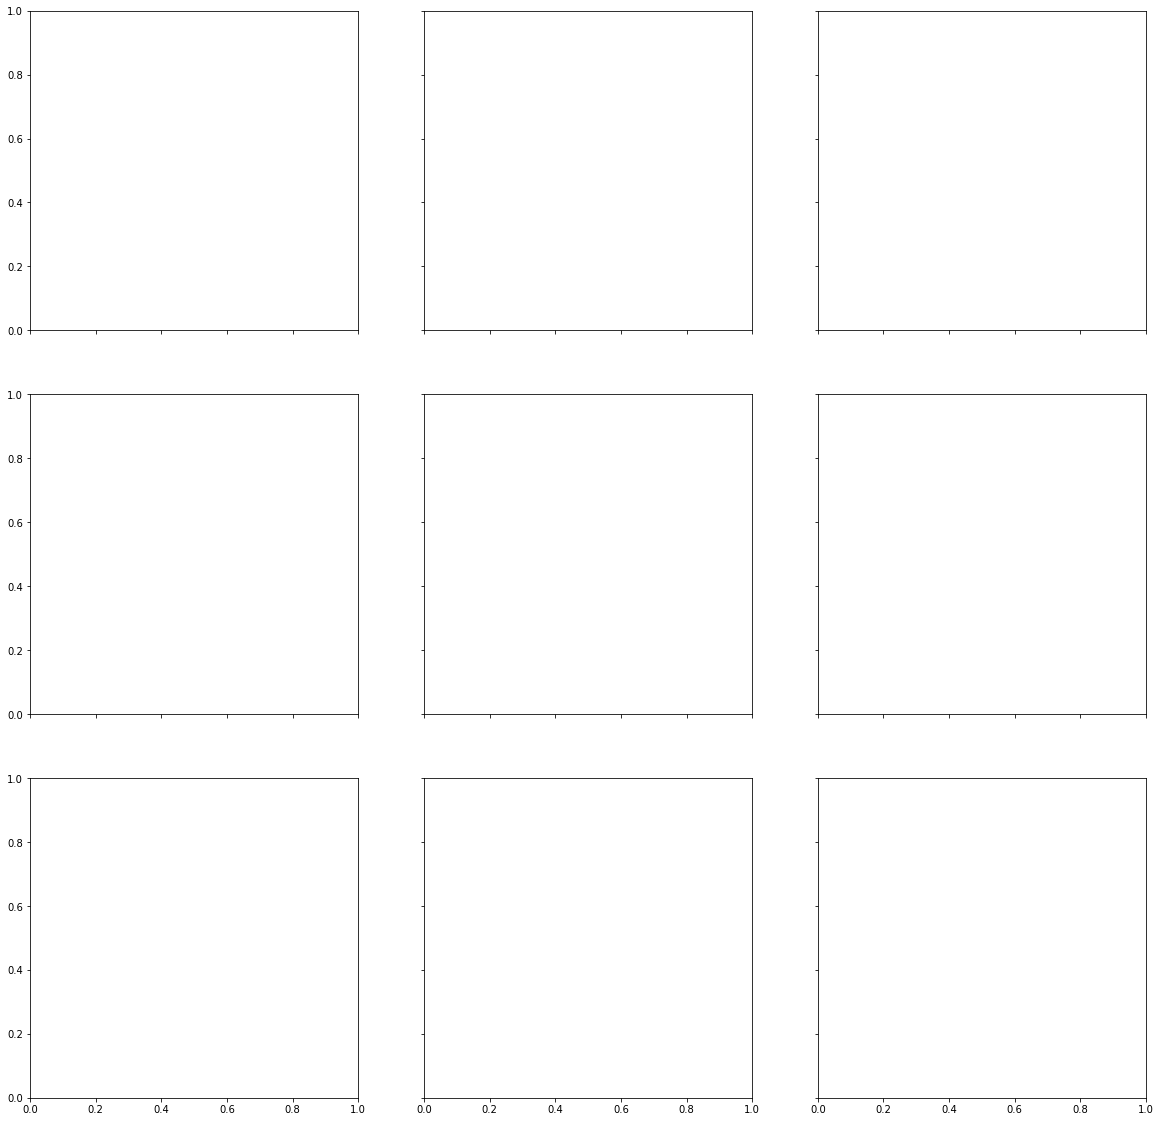

In [89]:
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
plt.show()

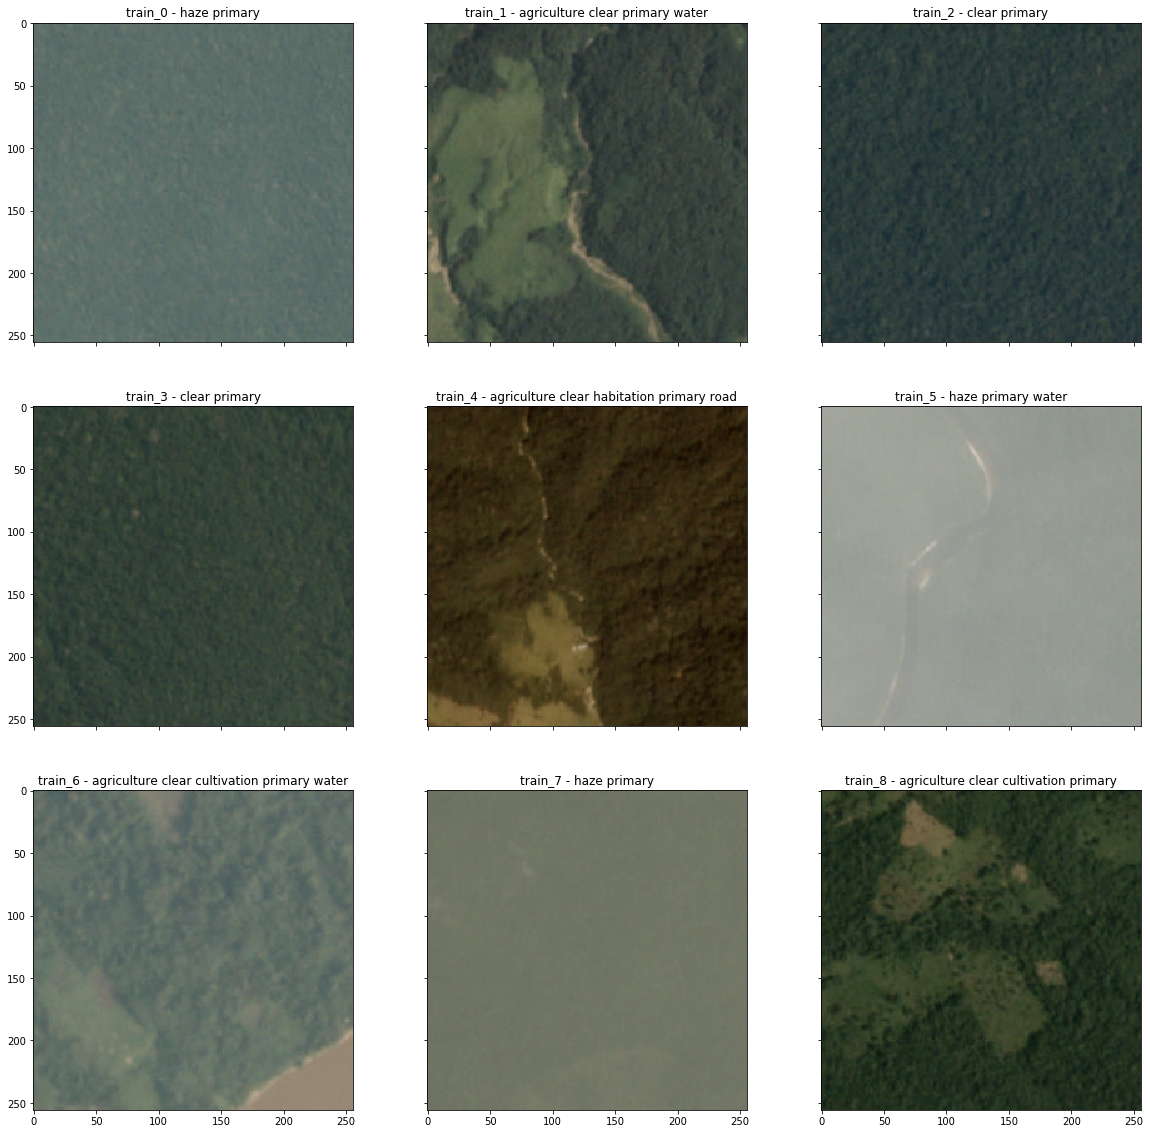

In [91]:
new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df[:9].values:
    img = cv2.imread(jpg_image_path.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()